# Parameterization and Waveform Differences

In this tutorial, we demonstrate using this package to load in and use parameterized sets of waveform differences as well as how to generate these sets ourselves. For more information, see [Equations and Notation](https://waveformuncertainty.readthedocs.io/en/latest/WFU_Equations.html). This notebook can be downloaded [here](https://github.com/RyanSR71/waveform_uncertainty/blob/main/docs/source/notebooks/Parameterization_Tutorial.ipynb).

The following cell is everything we need to import to run this tutorial. We also import the `WaveformUncertainty` package, which will need to be installed first. See [Installation](https://waveformuncertainty.readthedocs.io/en/latest/installation.html#installation).

In [2]:
import os
import numpy as np
import bilby
import matplotlib.pyplot as plt
import sys
import scipy
import lal
import random
import pesummary
from pesummary.gw.file.strain import StrainData
from pesummary.io import read
import requests
import pandas
import WaveformUncertainty as wfu

## Using Parameterized Waveform Differences

We will first demonstrate how parameterized waveform differences are loaded in and used. Here, we load in `parameterization_nsamples_1000.npy`, which contains residual phase difference.

In [3]:
# downloading the file and saving to a folder
try:
    os.mkdir('tutorial_files')
except:
    pass
file = requests.get('https://github.com/RyanSR71/waveform_uncertainty/raw/main/files/parameterization_nsamples_1000-4.npy', allow_redirects=True)
open("tutorial_files/parameterization_nsamples_1000.npy", 'wb').write(file.content)

# loading the file
parameterization = np.load("tutorial_files/parameterization_nsamples_1000.npy",allow_pickle=True)

We can use `WaveformUncertainty.recovery_from_parameterization` to turn the parameterized sets of waveform differences back into the waveform differences they represent: $\Delta\mathcal{A}_{T}$ and $\Delta\Phi_{T}$. This function constructs the waveform differences before the discontinuity using the Chebyshev polynomial coefficients $a$ and $b$ and then constructs the waveform differences after the discontinuity using other parameters: $f_{COR}$, $\Delta\mathcal{A}_{\mu}(f_{COR};\theta)$, $\Delta\phi_{\mu}(f_{COR};\theta)$, and $\Delta\Phi_{\mu}(f_{COR};\theta)$. The two sections of the waveform difference are then stitched together.

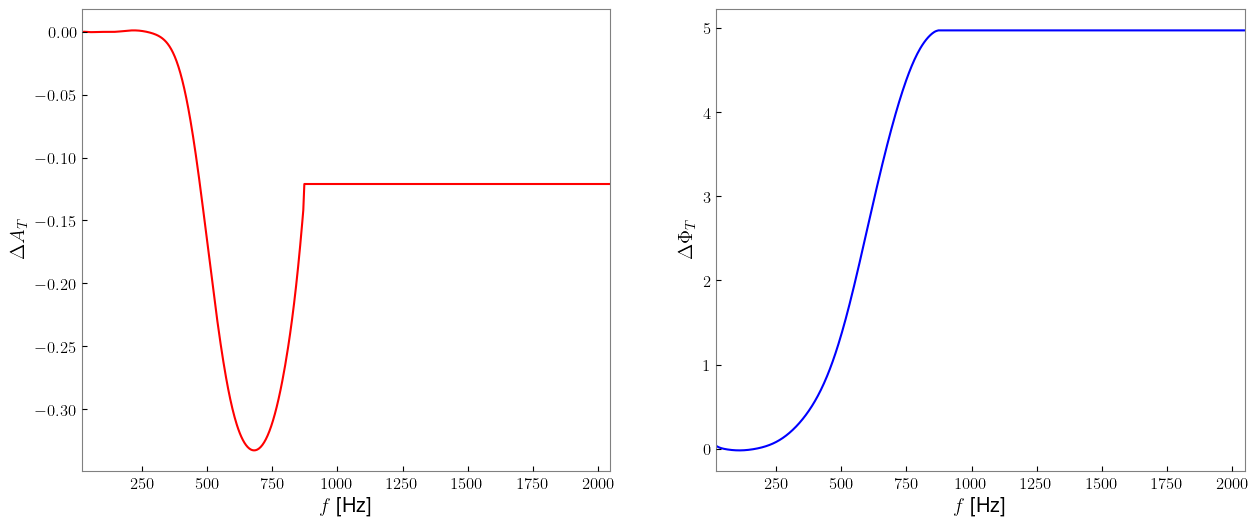

In [4]:
# we can choose any index to recover up to the number of sample sets in the file; in this case, 1000
index = random.randint(0,1000)

# recovering the frequency grid
frequency_grid = parameterization[index][1]

# recovering a draw of waveform differences
amplitude_difference_draw = wfu.recovery_from_parameterization('amplitude_difference',parameterization[index])
residual_phase_difference_draw = wfu.recovery_from_parameterization('phase_difference',parameterization[index])

# plotting
fig,ax = plt.subplots(1,2,figsize=(15,6))

# plotting the waveform differences
ax[0].plot(frequency_grid,amplitude_difference_draw,color='red')
ax[1].plot(frequency_grid,residual_phase_difference_draw,color='blue')

# plot settings
ax[0].grid(False)
ax[0].set_xlabel(r'$f$'+' [Hz]')
ax[0].set_ylabel(r'$\Delta{A}_{T}$')
ax[0].tick_params(direction='in')
ax[0].set_xlim(frequency_grid[0],frequency_grid[-1])

ax[1].grid(False)
ax[1].set_xlabel(r'$f$'+' [Hz]')
ax[1].set_ylabel(r'$\Delta\Phi_{T}$')
ax[1].tick_params(direction='in')
ax[1].set_xlim(frequency_grid[0],frequency_grid[-1])

plt.show()

From a parameterization file, we can also find the means and standard deviations of each waveform difference.  We define the standard deviations of $\Delta\mathcal{A}$ and $\Delta\Phi$ as amplitude and phase uncertainty respectively, $\delta\mathcal{A}$ and $\delta\Phi$. 

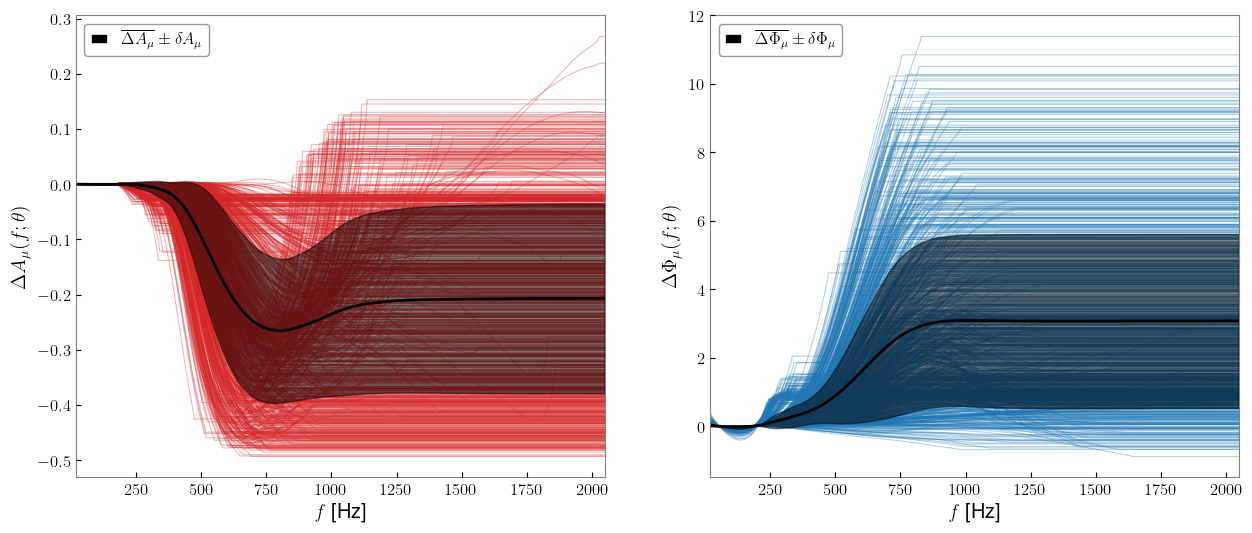

In [5]:
# finding the means and standard deviations
# linear_frequency_grid is returned as None, so we assign it to _ to ignore it
mean_amplitude_difference,amplitude_uncertainty,mean_phase_difference,residual_phase_uncertainty,_ = wfu.uncertainties_from_parameterization(parameterization)

# plotting
fig,ax = plt.subplots(1,2,figsize=(15,6))

frequency_grid = parameterization[0][1]

# plotting the means and standard deviations (uncertainties)
ax[0].plot(frequency_grid,mean_amplitude_difference,color='k',linewidth=2,zorder=2,label=r'$\overline{\Delta{A}_{\mu}}\pm\delta{A}_{\mu}$')
ax[0].fill_between(frequency_grid,mean_amplitude_difference-amplitude_uncertainty,mean_amplitude_difference+amplitude_uncertainty,color='k',alpha=0.5,zorder=2)
ax[1].plot(frequency_grid,mean_phase_difference,color='k',linewidth=2,zorder=2,label=r'$\overline{\Delta\Phi_{\mu}}\pm\delta\Phi_{\mu}$')
ax[1].fill_between(frequency_grid,mean_phase_difference-residual_phase_uncertainty,mean_phase_difference+residual_phase_uncertainty,color='k',alpha=0.5,zorder=2)

# plotting all of the draws of waveform difference
for i in range(len(parameterization)):
    ax[0].plot(frequency_grid,wfu.recovery_from_parameterization('amplitude_difference',parameterization[i]),color='tab:red',linewidth=0.75,alpha=0.35,zorder=1)
    ax[1].plot(frequency_grid,wfu.recovery_from_parameterization('phase_difference',parameterization[i]),color='tab:blue',linewidth=0.75,alpha=0.35,zorder=1)

# plot settings
ax[0].legend(fancybox=True,loc='upper left')
ax[0].grid(False)
ax[0].set_xlim(frequency_grid[0],frequency_grid[-1])
ax[0].set_xlabel(r'$\mathit{f}$'+" [Hz]")
ax[0].set_ylabel(r'$\Delta{A}_{\mu}(f;\theta)$')
ax[0].tick_params(direction='in')

ax[1].legend(fancybox=True,loc='upper left')
ax[1].grid(False)
ax[1].set_xlim(frequency_grid[0],frequency_grid[-1])
ax[1].set_xlabel(r'$\mathit{f}$'+" [Hz]")
ax[1].set_ylabel(r'$\Delta\Phi_{\mu}(f;\theta)$')
ax[1].tick_params(direction='in')

plt.show()

Finding the waveform uncertainties, $\delta\mathcal{A}$ and $\delta\Phi$, is important as this gives a model for the prior distributions of waveform differences, which can be sampled over. See [Sampling Over Waveform Uncertainty](https://waveformuncertainty.readthedocs.io/en/latest/notebooks/WFU_Sampling_Tutorial.html).

## Generating Waveform Model Differences

In the following sections, we look at generating waveform differences and then generating a parameterization file.

We first construct a prior of source parameters over which we want to generate waveform differences. Here, we choose a prior for binary neutron star analysis.

In [6]:
prior = bilby.core.prior.PriorDict()

prior['chirp_mass'] = bilby.core.prior.Uniform(name='chirp_mass',latex_label=r'$\mathcal{M}$',minimum=1.195,maximum=1.20,unit=r'$\mathrm{M}_{\odot}$')
prior['mass_ratio'] = bilby.core.prior.Uniform(name='mass_ratio',latex_label=r'$q$',minimum=0.334,maximum=1.000)
prior['chi_1'] = bilby.core.prior.Uniform(name='chi_1',latex_label=r'$\chi_{1}$',minimum=-0.05, maximum=0.05)
prior['chi_2'] = bilby.core.prior.Uniform(name='chi_2',latex_label=r'$\chi_{2}$',minimum=-0.05, maximum=0.05)
prior['lambda_1'] = bilby.core.prior.Uniform(name="lambda_1",latex_label=r'$\Lambda_{1}$',minimum=0.01, maximum=5000.0)
prior['lambda_2'] = bilby.core.prior.Uniform(name="lambda_2",latex_label=r'$\Lambda_{2}$',minimum=0.01, maximum=5000.0)
prior['phase'] = bilby.core.prior.Uniform(name='phase',latex_label=r'$\phi$',minimum=0,maximum=6.2831853071795865,boundary='periodic')
prior['luminosity_distance'] = bilby.gw.prior.UniformSourceFrame(name='luminosity_distance',latex_label=r'$\mathcal{L}_{D}$',minimum=1, maximum=100, unit='Mpc')
prior['geocent_time'] = bilby.core.prior.Uniform(name="geocent_time",latex_label=r'$t_{c}$',minimum=1187008882.3, maximum=1187008882.5,unit='s')
prior['phi_12'] = bilby.core.prior.Uniform(name='phi_12',latex_label=r'$\phi_{12}$',minimum=0,maximum=6.2831853071795865,boundary='periodic')
prior['phi_jl'] = bilby.core.prior.Uniform(name='phi_jl',latex_label=r'$\phi_{JL}$',minimum=0,maximum=6.2831853071795865,boundary='periodic')
prior['theta_jn'] = bilby.core.prior.Sine(name='theta_jn',latex_label=r'$\theta_{JN}$')
prior['psi'] = bilby.core.prior.DeltaFunction(name='psi',latex_label=r'$\psi$',peak=1.2695709169413083)
prior['ra'] = bilby.core.prior.DeltaFunction(name='ra',latex_label=r'$\alpha_{r}$',peak=3.44616)
prior['dec'] = bilby.core.prior.DeltaFunction(name='dec',latex_label=r'$\delta$',peak=-0.408084)

We can convert this prior into a dictionary of random samples, which is useful for having a fixed set of samples. Here, we choose 10000.

In [7]:
parameter_data = wfu.parameter_dict_from_prior(prior,10000)

Then, we draw a random sample from the dictionary to be our injection. If we wish to choose which sample we draw, we pass `index` as a kwarg. This can be any integer from 0 up to the length of the parameter dictionary. Due to the nature of binary neutron star waveform approximants, we assume that we cannot handle precessing spins, but we can handle tides. To change this, pass `precession=True` or `tides=False`.

In [12]:
injection = wfu.injection(parameter_data)

Here we set up our waveform generators with our injection passed as an argument. Because we are looking to generate model differences, we choose two different waveform approximants, `IMRPhenomPv2_NRTidalv2` and `SEOBNRv4T_surrogate`. To use surrogate and ROM waveform approximants, we require extra files that are not present in the base installation of `LAL`. To get these files, we change the `LAL_DATA_PATH` to a directory that contains them. These files and instructions on how to get them can be found [here](https://git.ligo.org/lscsoft/lalsuite-extra/). For this tutorial, we download the specific file we need for `SEOBNRv4T_surrogate`.

In [9]:
# downloading the file and saving to a folder
try:
    os.mkdir('tutorial_files/surrogate_files')
except:
    pass
file = requests.get('https://github.com/RyanSR71/waveform_uncertainty/raw/main/files/SEOBNRv4T_surrogate_v1.0.0.hdf5', allow_redirects=True)
open("tutorial_files/surrogate_files/SEOBNRv4T_surrogate_v1.0.0.hdf5", 'wb').write(file.content)

# changing the LAL_DATA_PATH
os.environ['LAL_DATA_PATH'] = 'tutorial_files/surrogate_files/'

In [10]:
waveform_arguments_1 = dict(waveform_approximant='IMRPhenomPv2_NRTidalv2', reference_frequency=50, 
                            catch_waveform_errors=True, f_low = 20.0, f_high=2048.0)

hf1 = bilby.gw.WaveformGenerator(parameter_conversion=bilby.gw.conversion.convert_to_lal_binary_neutron_star_parameters,
                    waveform_arguments=waveform_arguments_1,
                    frequency_domain_source_model=bilby.gw.source.lal_binary_neutron_star,
                    sampling_frequency=4096, 
                    duration=256,
                )

# SEOBNRv4T_surrogate does not support precessing spins, which is why we remove precessing spins from the injection
waveform_arguments_2 = dict(waveform_approximant='SEOBNRv4T_surrogate', reference_frequency=50, 
                            catch_waveform_errors=True, f_low = 20.0, f_high=2048.0)

hf2 = bilby.gw.WaveformGenerator(parameter_conversion=bilby.gw.conversion.convert_to_lal_binary_neutron_star_parameters,
                    waveform_arguments=waveform_arguments_2,
                    frequency_domain_source_model=bilby.gw.source.lal_binary_neutron_star,
                    sampling_frequency=4096, 
                    duration=256,
                )

16:44 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_neutron_star
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_neutron_star_parameters
16:44 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_neutron_star
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_neutron_star_parameters


With the waveform generators, we can calculate the waveform model differences, $\Delta\mathcal{A}_{\mu}$ and $\Delta\Phi_{\mu}$. If we pass the waveform generators into the `WaveformUncertainty.fd_model_difference`function, it will return model amplitude difference, $\Delta\mathcal{A}_{\mu}$, and raw model phase difference, $\Delta\phi_{\mu}$. The discontinuity correction frequency, $f_{COR}$, is also returned in the form of the position within the frequency grid where it occurs, `final_index`. `amplitude_difference_final_point` and `phase_difference_final_point` are also returned.

If injection parameters are not present in the waveform generators, add them to the `fd_model_difference` function as a kwarg.

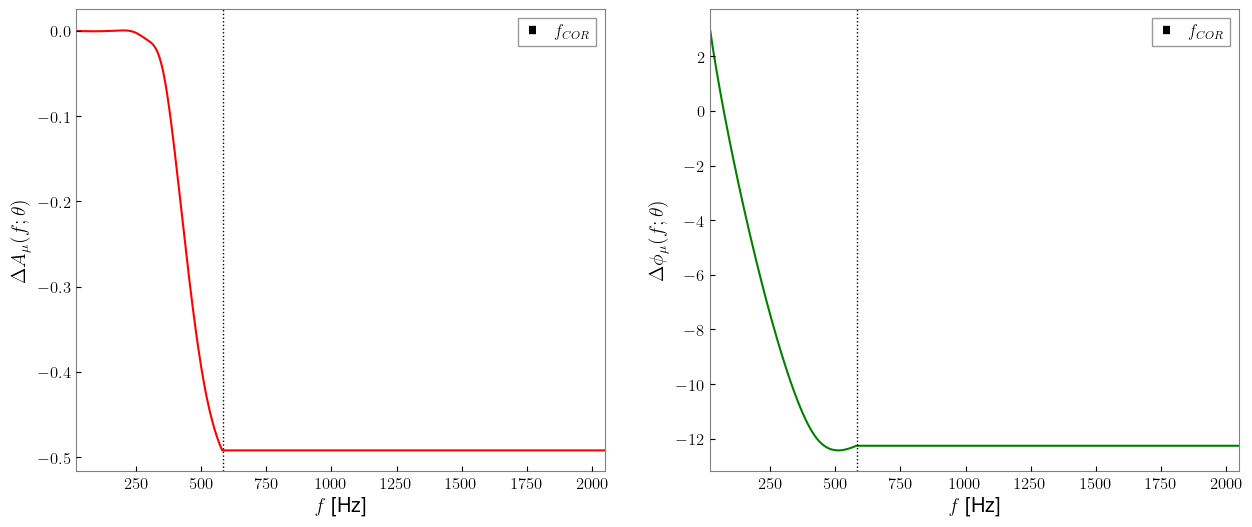

In [13]:
# calculating the waveform model differences
frequency_grid,amplitude_difference,raw_phase_difference,_,_,final_index = wfu.fd_model_difference(hf1,hf2,injection=injection)

# plotting
fig,ax = plt.subplots(1,2,figsize=(15,6))

# plotting the waveform differences
ax[0].plot(frequency_grid,amplitude_difference,color='red')
ax[1].plot(frequency_grid,raw_phase_difference,color='green')

# plotting the discontinuity correction frequency, f_COR
ax[0].axvline(frequency_grid[final_index],color='k',linestyle='dotted',linewidth=1,label=r'$f_{COR}$')
ax[1].axvline(frequency_grid[final_index],color='k',linestyle='dotted',linewidth=1,label=r'$f_{COR}$')

# plot settings
ax[0].set_xlim(frequency_grid[0],frequency_grid[-1])
ax[0].set_xlabel(r'$\mathit{f}$'+" [Hz]")
ax[0].set_ylabel(r'$\Delta{A}_{\mu}(f;\theta)$')
ax[0].tick_params(direction='in')
ax[0].legend()
ax[0].grid(False)

ax[1].set_xlim(frequency_grid[0],frequency_grid[-1])
ax[1].set_xlabel(r'$\mathit{f}$'+" [Hz]")
ax[1].set_ylabel(r'$\Delta\phi_{\mu}(f;\theta)$')
ax[1].tick_params(direction='in')
ax[1].legend()
ax[1].grid(False)

plt.show()

If power spectral density (PSD) data is passed as a kwarg `psd_data`, residual phase difference, $\Delta\Phi_{\mu}$, will be returned instead of raw phase difference, $\Delta\phi_{\mu}$. We load in GW170817 PSD data from [LIGO DCC](https://dcc.ligo.org/login/index.shtml).

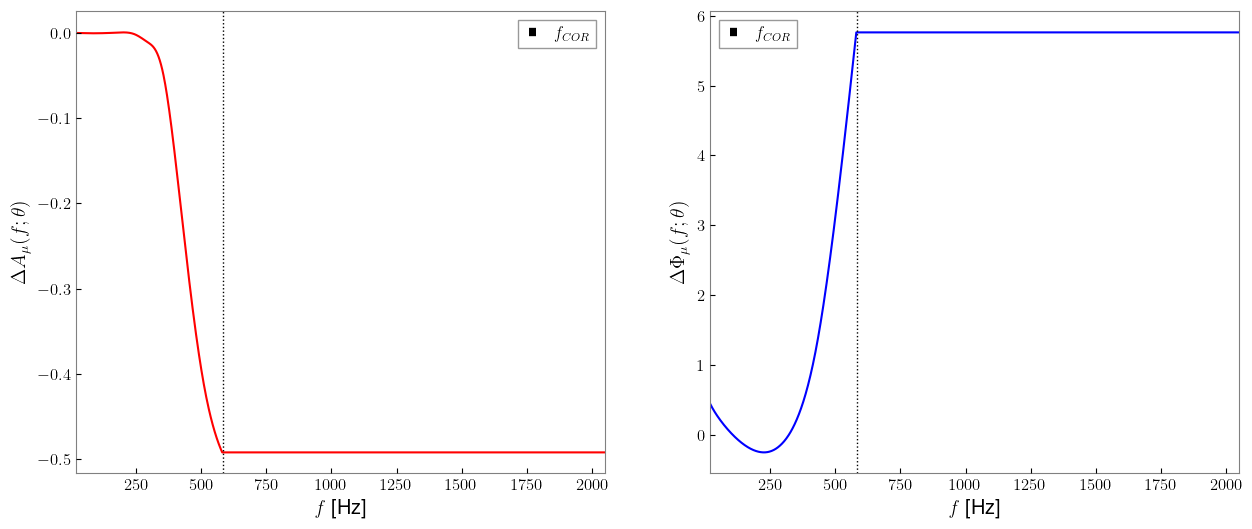

In [14]:
psd_data = np.loadtxt('https://dcc.ligo.org/public/0158/P1900011/001/GWTC1_GW170817_PSDs.dat',comments='#')

# calculating the waveform model differences
frequency_grid,amplitude_difference,residual_phase_difference,_,_,final_index = wfu.fd_model_difference(hf1,hf2,injection=injection,psd_data=psd_data)

# plotting
fig,ax = plt.subplots(1,2,figsize=(15,6))

# plotting the waveform differences
ax[0].plot(frequency_grid,amplitude_difference,color='red')
ax[1].plot(frequency_grid,residual_phase_difference,color='blue')

# plotting the discontinuity correction frequency, f_COR
ax[0].axvline(frequency_grid[final_index],color='k',linestyle='dotted',linewidth=1,label=r'$f_{COR}$')
ax[1].axvline(frequency_grid[final_index],color='k',linestyle='dotted',linewidth=1,label=r'$f_{COR}$')

# plot settings
ax[0].set_xlim(frequency_grid[0],frequency_grid[-1])
ax[0].set_xlabel(r'$\mathit{f}$'+" [Hz]")
ax[0].set_ylabel(r'$\Delta{A}_{\mu}(f;\theta)$')
ax[0].tick_params(direction='in')
ax[0].legend()
ax[0].grid(False)

ax[1].set_xlim(frequency_grid[0],frequency_grid[-1])
ax[1].set_xlabel(r'$\mathit{f}$'+" [Hz]")
ax[1].set_ylabel(r'$\Delta\Phi_{\mu}(f;\theta)$')
ax[1].tick_params(direction='in')
ax[1].legend()
ax[1].grid(False)

plt.show()

## Generating a Parameterization File

`WaveformUncertainty.parameterization` takes the previous steps and iterates them many times, but fits a Chebyshev polynomial series up to the discontinuity correction frequency, $f_{COR}$, and saves all parameters necessary for reproducing the data. To run the function, we pass two waveform generators, a parameter dictionary, and the number of draws we want. Parameterization will fail if its success rate is lower than the `fit_threshold`, which defaults to 75%. Typically, the parameterization success rate averages at around 90%. Each draw of waveform difference takes about one second to get through, so choosing high `nsamples` values can take up a lot of time; 15-20 minutes for 1000 samples. By default, it is guaranteed that the parameterized waveform differences, $\Delta\mathcal{A}_{T}$ and $\Delta\Phi_{T}$, will match their corresponding $\Delta\mathcal{A}_{\mu}$ and $\Delta\Phi_{\mu}$ within $2$% in $\Delta\mathcal{A}$ and $2^{\circ}$ in $\Delta\Phi$. These boundaries can be changed using `max_amplitude_error` and `max_phase_error`.

In [15]:
waveform_arguments_1 = dict(waveform_approximant='IMRPhenomPv2_NRTidalv2', reference_frequency=50, 
                            catch_waveform_errors=True, f_low = 20.0, f_high=2048.0)

# waveform generator named after IMRPhenomPv2_NRTidalv2
IMR_waveform = bilby.gw.WaveformGenerator(parameter_conversion=bilby.gw.conversion.convert_to_lal_binary_neutron_star_parameters,
                    waveform_arguments=waveform_arguments_1,
                    frequency_domain_source_model=bilby.gw.source.lal_binary_neutron_star,
                    sampling_frequency=4096, 
                    duration=256,
                )

waveform_arguments_2 = dict(waveform_approximant='SEOBNRv4T_surrogate', reference_frequency=50, 
                            catch_waveform_errors=True, f_low = 20.0, f_high=2048.0)

# waveform generator named after SEOBNRv4T_surrogate
EOB_waveform = bilby.gw.WaveformGenerator(parameter_conversion=bilby.gw.conversion.convert_to_lal_binary_neutron_star_parameters,
                    waveform_arguments=waveform_arguments_2,
                    frequency_domain_source_model=bilby.gw.source.lal_binary_neutron_star,
                    sampling_frequency=4096, 
                    duration=256,
                )

In [16]:
parameterization=wfu.parameterization(IMR_waveform,EOB_waveform,parameter_data,25,psd_data=psd_data,fit_threshold=10)

Generating Waveform Differences and Parameterizing...
[====================================================================================================] 100.0% 
Done!

Time Elapsed: 16.548 seconds

Parameterized Waveform Model Difference data was created with 25 sample sets at a final parameterization rate of 89.2857%.



This can then be saved as a `.npy` file using `numpy.save`.

In [17]:
try:
    os.mkdir('tutorial_files')
except:
    pass

np.save('tutorial_files/parameterization_example.npy',parameterization)

We can use [pandas](https://pandas.pydata.org/) dataframes to see the structure of the parameterization table:

In [18]:
pandas.DataFrame(parameterization)

,0,1,2,3,4,5,6,7
0,1050,"[20.0, 20.092885431736743, 20.186202248644943,...","[-0.014354301090414842, 0.0015059049886317162,...","[0.08072035468695848, -0.004041588134875887, 4...",811,-0.343107,4.281334,"{'chirp_mass': 1.1989056786545456, 'mass_ratio..."
1,8130,"[20.0, 20.092885431736743, 20.186202248644943,...","[-0.012126468193984628, 0.0013253514958364038,...","[0.12837719429435868, -0.006665185227650268, 7...",818,0.028378,3.263181,"{'chirp_mass': 1.1971594936190941, 'mass_ratio..."
2,8277,"[20.0, 20.092885431736743, 20.186202248644943,...","[-0.020304251661008597, 0.002143440115884493, ...","[0.05098262559620914, -0.001957327289827361, 1...",830,-0.392097,5.577824,"{'chirp_mass': 1.1999254984026033, 'mass_ratio..."
3,6393,"[20.0, 20.092885431736743, 20.186202248644943,...","[-0.011643850716126405, 0.0012825306517635342,...","[0.12583308813430083, -0.006806095857645971, 8...",809,-0.317598,6.195227,"{'chirp_mass': 1.1994079443921146, 'mass_ratio..."
4,8379,"[20.0, 20.092885431736743, 20.186202248644943,...","[-0.0126065502411233, 0.0013554972372450168, -...","[0.1116239398670461, -0.005727541833233139, 6....",819,0.034871,2.843975,"{'chirp_mass': 1.195994704710684, 'mass_ratio'..."
5,715,"[20.0, 20.092885431736743, 20.186202248644943,...","[0.003972564179971515, -0.00033211058455792186...","[0.06227229078722056, -0.00289076815865233, 2....",922,-0.096666,0.144721,"{'chirp_mass': 1.1977763731287534, 'mass_ratio..."
6,2835,"[20.0, 20.092885431736743, 20.186202248644943,...","[0.0025499791514410133, -0.0002119809348339646...","[0.09995830239145445, -0.00572193057470948, 6....",868,0.083553,0.834665,"{'chirp_mass': 1.1975494896147316, 'mass_ratio..."
7,7348,"[20.0, 20.092885431736743, 20.186202248644943,...","[-0.0015990725790257579, 0.0001697007281806073...","[0.07926134770548296, -0.004608855797323987, 5...",888,-0.05497,0.117108,"{'chirp_mass': 1.1971212695667246, 'mass_ratio..."
8,7432,"[20.0, 20.092885431736743, 20.186202248644943,...","[0.003948205276125209, -0.00032967293976708363...","[0.08234789186305733, -0.004309423527342546, 4...",901,-0.005407,0.176516,"{'chirp_mass': 1.197901204858109, 'mass_ratio'..."
9,3394,"[20.0, 20.092885431736743, 20.186202248644943,...","[0.00019215854298395424, -6.180169980371804e-0...","[0.061748226332759934, -0.003026827753241425, ...",936,-0.113548,0.269737,"{'chirp_mass': 1.1956009101700364, 'mass_ratio..."
